In [ ]:
# Download the data and unzip it
!gdown --fuzzy https://drive.google.com/file/d/1GztoCT0Hjmt-Yqw-6rfiwu2QYkRI1uI5/view?usp=sharing
#!gdown --fuzzy https://drive.google.com/file/d/11PAq6-CnRZk9tcTxeyS4oZttk3GQU6IV/view?usp=sharing # Uncomment this line if the above link doesn't work
#!gdown --fuzzy https://drive.google.com/file/d/1aAd8aZ-YatFmyrH8d93akpYexhHXBmaG/view?usp=share_link # Uncomment this line if the above link doesn't work
!unzip train_dataset.zip
!rm train_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1GztoCT0Hjmt-Yqw-6rfiwu2QYkRI1uI5
To: /content/train_dataset.zip
100% 124M/124M [00:01<00:00, 67.6MB/s]
Archive:  train_dataset.zip
  inflating: train_dataset/meta.csv  
   creating: train_dataset/wavs/
  inflating: train_dataset/wavs/1.wav  
  inflating: train_dataset/wavs/10.wav  
  inflating: train_dataset/wavs/100.wav  
  inflating: train_dataset/wavs/101.wav  
  inflating: train_dataset/wavs/102.wav  
  inflating: train_dataset/wavs/103.wav  
  inflating: train_dataset/wavs/104.wav  
  inflating: train_dataset/wavs/105.wav  
  inflating: train_dataset/wavs/106.wav  
  inflating: train_dataset/wavs/107.wav  
  inflating: train_dataset/wavs/108.wav  
  inflating: train_dataset/wavs/109.wav  
  inflating: train_dataset/wavs/11.wav  
  inflating: train_dataset/wavs/110.wav  
  inflating: train_dataset/wavs/111.wav  
  inflating: train_dataset/wavs/112.wav  
  inflating: train_dataset/wavs/113.wav  
  inflating: train_dataset/wavs/114

In [ ]:
!unzip generate_audio.zip -d train_dataset/wavs/

Archive:  generate_audio.zip
   creating: train_dataset/wavs/generate_audio/.ipynb_checkpoints/
  inflating: train_dataset/wavs/generate_audio/0_flowavenet_audio.wav  
  inflating: train_dataset/wavs/generate_audio/1_flowavenet_audio.wav  
  inflating: train_dataset/wavs/generate_audio/10_flowavenet_audio.wav  
  inflating: train_dataset/wavs/generate_audio/100_flowavenet_audio.wav  
  inflating: train_dataset/wavs/generate_audio/101_flowavenet_audio.wav  
  inflating: train_dataset/wavs/generate_audio/102_flowavenet_audio.wav  
  inflating: train_dataset/wavs/generate_audio/103_flowavenet_audio.wav  
  inflating: train_dataset/wavs/generate_audio/104_flowavenet_audio.wav  
  inflating: train_dataset/wavs/generate_audio/105_flowavenet_audio.wav  
  inflating: train_dataset/wavs/generate_audio/106_flowavenet_audio.wav  
  inflating: train_dataset/wavs/generate_audio/107_flowavenet_audio.wav  
  inflating: train_dataset/wavs/generate_audio/108_flowavenet_audio.wav  
  inflating: train_da

In [ ]:
# Install dependencies
!pip install "torch>=1.12.1,<2"
!pip install "numpy>=1.22.0"
!pip install "scipy>=1.4.1"
!pip install "librosa>=0.10.0"
!pip install "inflect>=0.2.5"
!pip install "numba>=0.48.0"
!pip install "soundfile==0.12.1"
!pip install "tqdm"

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# dataset.py
import os

import librosa
import numpy as np
from torch.utils.data import Dataset

max_time_steps = 16000
upsample_conditional_features = True
hop_length = 256

class HW5Dataset(Dataset):
    def __init__(self, meta):
        self.meta = os.path.realpath(meta)
        self.paths, self.labels = self.collect_files()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        """When iterating through the dataset, the first returned value
        is the original wav file, the second is the mel spectrogram, and
        the third is the label.
        e.g. wav, mel_spectrogram, label = next(iter(val_dataset))
        """
        wav, sr = librosa.load(self.paths[idx], sr=22050)

        wav = wav / np.abs(wav).max() * 0.999
        n_fft = 1024
        hop_length = 256

        mel_spectrogram = librosa.feature.melspectrogram(
            y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=8,
            fmin=125, fmax=7600).T

        mel_spectrogram = torch.tensor(mel_spectrogram)
        label = torch.FloatTensor([self.labels[idx]]).long()
        return mel_spectrogram, label

    def collect_files(self):
        paths = []
        labels = []
        with open(self.meta, "r") as f:
            for line in f:
                file, label = line.strip().split(',')
                paths.append(os.path.realpath(file))
                labels.append(float(label))

        return paths, labels

ModuleNotFoundError: No module named 'librosa'

In [ ]:
# model.py
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau


class HW5Model(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.setup_model(**kwargs)

    def setup_model(
            self,
            input_size: int = 8,
            hidden_size: int = 16,
            num_layers: int = 2,
            lr: float = 1e-3,
            device: torch.device = torch.device('cpu')
            ) -> None:
        """Setup model architecture here. To improve the performance of
        the model, You can try different hyperparameters here, or change
        the network architecture. Note that the forward function might
        not be compatible with the new architecture.

        Parameters
        ----------
        input_size: int
            input size of the LSTM network.

        hidden_size: int
            hidden size of the LSTM network.

        num_layers: int
            number of layers of the LSTM network.

        lr: float
            learning rate of the optimizer.

        device: torch.device
            context-manager that changes the selected device.
        """
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.device = device
        self.weight_for_positives = torch.tensor([[400/600]]).to(self.device)
        self.loss = torch.nn.BCEWithLogitsLoss(pos_weight=self.weight_for_positives)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, patience=2, factor=0.5)

        self.to(device)
        return

    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Parameters
        ----------
        batch: torch.Tensor
            input tensor of shape (batch_size, n_time_steps, input_size).

        Returns
        -------
        torch.Tensor:
            output tensor of shape (batch_size,).
        """
        embed, _ = self.lstm(batch)
        embed = torch.mean(embed, dim=1)
        output = self.output_layer(embed)
        output = torch.squeeze(output)
        return output

    def train_epochs(
            self,
            train_loader: DataLoader,
            val_loader: DataLoader,
            patience: int = 5,
            max_n_epochs: int = 15) -> None:
        """Train the model with max number of epochs. You should finish the TODOs in this function.

        Parameters
        ----------
        train_loader: torch.utils.data.DataLoader
            dataloader for training data.

        val_loader: torch.utils.data.DataLoader
            dataloader for validation data.

        patience: int
            number of epochs to wait before early stop, default to 5.

        max_n_epochs: int
            maximum number of epochs to train, default to 10.
        """



        # initialize the best loss  (used for early stopping)
        best_loss = np.inf
        early_stop_counter = patience


        for epoch in range(max_n_epochs):
            current_lr = self.optimizer.param_groups[0]['lr']
            print(f'Current Learning Rate: {current_lr}')
            self.train()
            train_loss_logs = []
            for (mels, labels) in tqdm(train_loader):
                mels = mels.to(self.device)
                labels = labels.to(self.device)
                # TODO (5P): change the following, make forward pass, and save the result to y_pred.
                # CHECK: self.forward
                # CHECK: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-optim
                y_pred = self.forward(mels)

                # TODO (5P): change the following, compute loss and perform back propagation.
                # CHECK: self.loss
                # CHECK: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
                # CHECK: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-optim
                y_pred = y_pred.unsqueeze(0)
                labels = labels.unsqueeze(0)

                # print(y_pred.shape)
                # labels = labels.view_as(y_pred)
                # print(labels.shape)

                train_loss = self.loss(y_pred, labels.float())

                train_loss_logs.append(train_loss.item())

                # TODO (5P): update the weights of the network through gradient descent.
                # CHECK: self.optimizer
                # CHECK: https://pytorch.org/docs/stable/optim.html
                # CHECK: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-optim
                self.optimizer.zero_grad()
                train_loss.backward()
                self.optimizer.step()


                # log training loss
                train_loss_logs.append(train_loss.item())

            # take the average of training loss
            average_train_loss = np.mean(np.array(train_loss_logs))

            self.eval()
            val_loss_logs = []
            with torch.no_grad():
              for mels, labels in tqdm(val_loader):
                  mels = mels.to(self.device)
                  labels = labels.to(self.device)
                  # TODO (5P): change the following, make forward pass, and save the result to y_pred.
                  # CHECK: self.forward
                  # CHECK: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-optim
                  y_pred = self.forward(mels)


                  # TODO (5P): change the following, compute loss.
                  # CHECK: self.loss
                  # CHECK: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
                  y_pred = y_pred.unsqueeze(0)
                  labels = labels.unsqueeze(0)
                  val_loss = self.loss(y_pred, labels.float())
                  val_loss_logs.append(val_loss.item())

                  # log validation loss
                  val_loss_logs.append(val_loss.item())

            # take the average of validation loss
            average_val_loss = np.mean(np.array(val_loss_logs))
            self.scheduler.step(average_val_loss)

            print(f'{epoch+1:03}\ttrain_loss: {average_train_loss:.2f}\tval_loss: {average_val_loss:.2f}')

            if average_val_loss < best_loss:
               # TODO (5P): implement early stopping here, if the validation loss is smaller than the
               # current best. Save the model, update the best loss and reset the early stop counter.
               # CHECK: https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended
               # Please name the model’s state_dict as best_model.ckpt)
               best_loss = average_val_loss
               early_stop_counter = patience
               torch.save(self.state_dict(), 'best_model.ckpt')
            else:
               early_stop_counter -= 1
               if early_stop_counter == 0:
                  print("Early stopping triggered")
                  break

        return

    def predict_prob(self, dataloader: torch.utils.data.DataLoader) -> np.array:
        """Predict the probability of the audio class based on trained.
        the output should be of shape (n_samples,). Each element is the
        predicted probability for the sample being AI generated recoding.

        Parameters
        ----------
        data_loader: torch.utils.data.DataLoader
            dataloader to be predicted.

        Returns
        -------
        np.array:
            the output should be of shape (n_samples,). Each element is the
            predicted probability for the sample being AI generated recoding.
            e.g. np.array([0.03111489, 0.6505939 , 0.16935825, ...], dypte=np.float32)
        """
        self.eval()
        probs = []
        with torch.no_grad():
          for (mels, labels) in tqdm(dataloader):
              # TODO (10P): change this. The model only predict the
              # logits of the probability of AI generated recording. You
              # need to compute the probability of both real recording and
              # AI generated recording.
              # CHECK: https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html
              mels = mels.to(self.device)
              logits = self.forward(mels)
              probs.append(torch.sigmoid(logits).cpu().numpy())  # Convert logits to probabilities

        probs_np = np.concatenate(probs)
        return probs_np

    def predict(self, dataloader: torch.utils.data.DataLoader) -> np.array:
        """Predict the output based on trained model, the output should
        be of shape (n_samples,). Output 0 for the sample if the model
        predict the sample to be real recording, 1 otherwise.

        Parameters
        ----------
        data_loader: torch.utils.data.DataLoader
            dataloader to be predicted.

        Returns
        -------
        np.array:
            output 0 for the sample if the model predict the sample to
            be real recording, 1 otherwise.
            e.g. np.array([0, 1, 0], dypte=np.float32)
        """
        # TODO (10P): change this, it would be easier to implement
        # `predict_prob` first, and start from the output of it.
        probabilities = self.predict_prob(dataloader)
        predictions = np.where(probabilities > 0.5, 1, 0)  # Threshold at 0.5
        return predictions


    def evaluate(self, y_true: np.array, y_prob: np.array) -> float:
        """Evaluate the output based on the ground truth, the output
        should be the area under precision recall curve.

        Parameters
        ----------
        y_true: np.array
            the ground truth of the data.

        y_pred: np.array
            the output of model.predict_prob.

        Returns
        -------
        float:
            the area under precision recall curve.
        """
        # TODO (10P): return value should be the AUROC given y_true and y_prob, and you need to plot the ROC curve.
        # CHECK: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
        # CHECK: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

        # Compute ROC curve and AUROC
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        auroc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auroc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

        return auroc

In [ ]:
# main.py
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
  mels, labels = zip(*batch)
  # Pad the mel pectrogram to make them have the same length
  mels = pad_sequence(mels, batch_first=True)
  return mels, torch.FloatTensor(labels)

In [39]:
from google.colab import drive
drive.mount('/content/drive')
# Add the audio you generated to the training data. Remember to modify the meta.csv, and all the generated data should be label as 1 (generated from AI)
!find /content/drive/MyDrive/generate_audio/ -name "*flowavenet*" -exec cp {} /content/train_dataset/wavs/ \;
%cd /content/
!find train_dataset -name "*flowavenet*wav" -exec echo {},1 \; >> /content/train_dataset/meta.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot create regular file '/content/train_dataset/wavs/': No such file or directory
cp: cannot create regular file '/content/train_dataset/wavs/': No such file or directory
cp: cannot create regular file '/content/train_dataset/wavs/': No such file or directory
cp: cannot create regular file '/content/train_dataset/wavs/': No such file or directory
cp: cannot create regular file '/content/train_dataset/wavs/': No such file or directory
cp: cannot create regular file '/content/train_dataset/wavs/': No such file or directory
cp: cannot create regular file '/content/train_dataset/wavs/': No such file or directory
cp: cannot create regular file '/content/train_dataset/wavs/': No such file or directory
cp: cannot create regular file '/content/train_dataset/wavs/': No such file or directory
cp: cannot create regular file '/content/train_dataset/wavs/': No such

In [2]:
# main.py
import torch
from torch.utils.data import DataLoader

RANDOM_STATE = 2023
dataset = HW5Dataset('train_dataset/meta.csv')
random_seed_generator = torch.Generator().manual_seed(RANDOM_STATE)

# TODO (5P): Create training and validation dataset based on `dataset`
# and `random_seed_generator`. You should split the dataset into 80%
# samples for the training, and 20% samples for the validation. You
# should use `random_seed_generator` to ensure consistency of the
# result.
# CHECK: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

total_size = len(dataset)
print(total_size)

train_size = int(0.8 * total_size)  # 80% of the total size
val_size = total_size - train_size  # Remaining 20% for validation

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=random_seed_generator)

# TODO (5P): Create training and validation data loader based on
# `train_dataset` and `val_dataset`. For val_loader, please set
# `shuffle=False` for the consistency of the result.
# CHECK: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders
# e.g. train_loader = DataLoader(..., collate_fn=collate_batch)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)


# Optional: change different hyperparameters, to get the best model.
hidden_size = 16
num_layers = 4
lr = 8e-3
patience = 5
max_n_epochs = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = HW5Model(hidden_size=hidden_size, num_layers=num_layers, lr=lr, device=device)
model.train_epochs(train_loader, val_loader, patience=patience, max_n_epochs=max_n_epochs)

NameError: name 'HW5Dataset' is not defined

100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Accuracy on validation set: 0.93


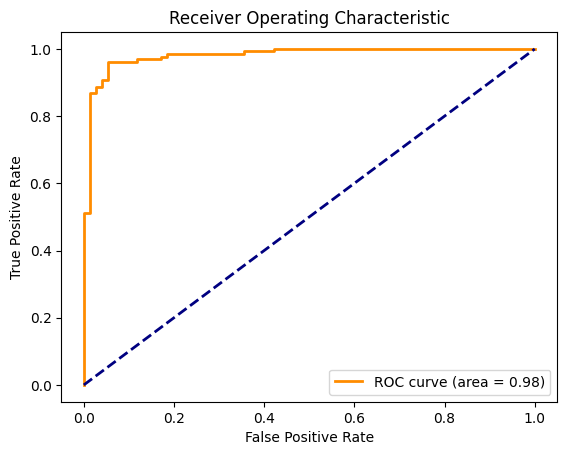

Area under precision recall curve on validation set: 0.98


In [ ]:
# Load your best model and plot the ROC curve of validation data
model.load_state_dict(torch.load("best_model.ckpt"))
y_pred_prob = model.predict_prob(val_loader)
y_pred = model.predict(val_loader)
y_true = torch.concat([labels for mel, labels in val_loader]).numpy().astype('float32')
print(f'Accuracy on validation set: {(y_pred == y_true).sum() / len(y_true):.2f}')
print(f'Area under precision recall curve on validation set: {model.evaluate(y_true, y_pred_prob):.2f}')

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred)
print(y_true)
print(y_pred)
print(f1)

[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.]
[0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0
 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1
 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 0 1 0 1 

In [1]:
from google.colab import files
# Download the parameters of the best model
files.download('./best_model.ckpt')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
## TA will evaluate you model as follows

test_dataset = val_dataset
test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)

model = HW5Model(hidden_size=hidden_size, num_layers=num_layers)
model.load_state_dict(torch.load("./best_model.ckpt"))

y_pred_prob = model.predict_prob(test_loader)
y_pred = model.predict(test_loader).astype('float32')
y_true = torch.concat([labels for mel, labels in val_loader]).numpy().astype('float32')

print(f'Accuracy on test set: {(y_pred == y_true).sum() / len(y_true):.2f}')
print(f'Area under precision recall curve on test set: {model.evaluate(y_true, y_pred_prob):.2f}')

from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred)
print(f1)


NameError: name 'val_dataset' is not defined